# cluster_photometry.ipynb

I only need cluster photometry for my pipeline as part of my artificial cluster tests. There I want to have clusters with a range of magnitudes. Therefore I need to properly measure the magnitude. I'll follow the explanation set out in [Adamo et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...841..131A/abstract). Specifically, Section 2.2.1 about the automated pipeline. Step 2 shows that the cluster aperture used is the integer pixel value that includes more than 50% of the cluster flux. According to Figure 2, this looks like 4 pixels. There is also a sky annulus, which is at 7 pixels and is 1 pixel wise (see Step 4). This notebook will check that I can do this well. I will also calibrate the zeropoint with this. Since I change my images to be in electrons, the image zeropoint is now off. I also need to incorporate the aperture corrections. I can attempt to derive this correctly:
$$ m = -2.5 \log(F) + C - C_{apcor}$$
$$ m = -2.5 \log(F_{me} / \mathrm{exptime}) + 25.731 - 0.634$$
$$ m = -2.5 \log(F_{me}) + 2.5 \log(\mathrm{exptime}) + 25.731 - 0.634$$
$$ m = -2.5 \log(F_{me}) + 2.5 \log(858) + 25.731 - 0.634$$
$$ m = -2.5 \log(F_{me}) + 32.43$$

But I tried this, and it didn't work. I was not able to reproduce the cluster magnitudes from the catalog. I manually messed with the zeropoint and found that 32.2 is a better choice. I'm not sure what is causing the difference. But for my purposes, I don't think it matter. I'm still able to reproduce the cluster magnitudes, which is good enough for the purposes of making artificial clusters.

In [1]:
import sys
from pathlib import Path
from astropy import table
import numpy as np
import betterplotlib as bpl

bpl.set_style()

In [2]:
# need to add the correct path to import utils
legus_home_dir = Path(".").resolve().parent
sys.path.append(str(legus_home_dir / "pipeline"))
import utils
import fit_utils

In [3]:
data_dir = legus_home_dir / "data" / "ngc628-c"
image_data, _, _ = utils.get_drc_image(data_dir)

cat_name = (
    f"final_catalog_final_30_pixels_psf_"
    f"my_stars_15_pixels_2x_oversampled.txt"
)
cat_path = data_dir / "size" / cat_name
cat = table.Table.read(str(cat_path), format="ascii.ecsv")

# Define the function to measure the cluster magnitude

In [4]:
print(2.5 * np.log10(858) + 25.731 - 0.634)

32.43071821962177


In [5]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [6]:
def measure_magnitude(snapshot, x_cen, y_cen):
    aperture = 4
    zeropoint = 32.2
    
    flux_source = 0
    flux_sky = 0
    n_pixels_source = 0
    n_pixels_sky = 0
    for x in range(snapshot.shape[1]):
        for y in range(snapshot.shape[0]):
            dist = distance(x, y, x_cen, y_cen)
            if dist <= aperture:
                flux_source += snapshot[y][x]
                n_pixels_source += 1
                
            # then do the sky annulus
            if 6.5 <= dist < 7.5:
                flux_sky += snapshot[y][x]
                n_pixels_sky += 1
                
    # then subtract the background
    flux_source -= flux_sky * (n_pixels_source / n_pixels_sky)
    
    return -2.5 * np.log10(flux_source) + zeropoint

# Then use this on clusters

In [7]:
cat["mag_F555W_my"] = 0.0
for row in cat:
    
    # create the snapshot. We use ceiling to get the integer pixel values as python
    # indexing does not include the final value. So when we calcualte the offset, it
    # naturally gets biased low. Moving the center up fixes that in the easiest way.
    x_cen = int(np.ceil(row["x_pix_single"] - 1))
    y_cen = int(np.ceil(row["y_pix_single"] - 1))

    # Get the snapshot, based on the size desired.
    # Since we took the ceil of the center, go more in the negative direction (i.e.
    # use ceil to get the minimum values). This only matters if the snapshot size is odd
    snapshot_size = 30
    x_min = x_cen - int(np.ceil(snapshot_size / 2.0))
    x_max = x_cen + int(np.floor(snapshot_size / 2.0))
    y_min = y_cen - int(np.ceil(snapshot_size / 2.0))
    y_max = y_cen + int(np.floor(snapshot_size / 2.0))

    data_snapshot = image_data[y_min:y_max, x_min:x_max].copy()

    snapshot_x_cen = row["x_pix_single"] - 1 - x_min
    snapshot_y_cen = row["y_pix_single"] - 1 - y_min

    row["mag_F555W_my"] = measure_magnitude(data_snapshot,
                                           snapshot_x_cen, snapshot_y_cen)

<ipython-input-6-494f3ed130d5>:24: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux_source) + zeropoint


# Then compare

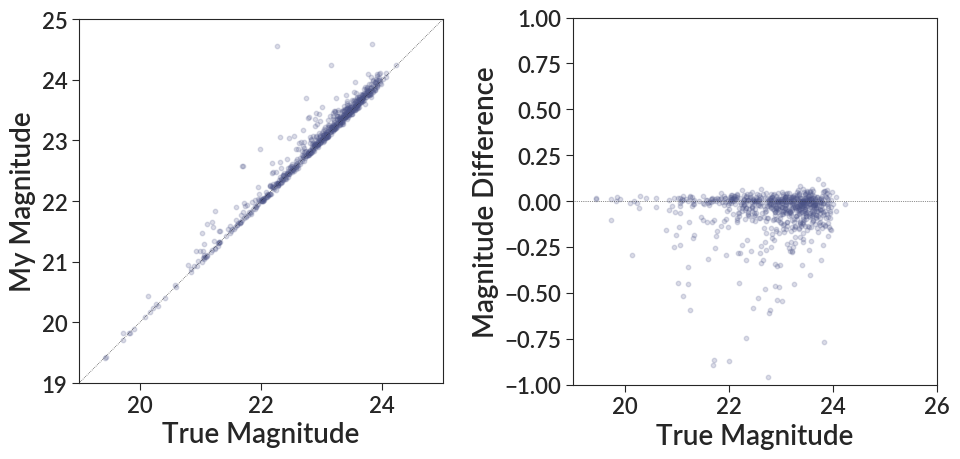

In [8]:
fig, axs = bpl.subplots(ncols=2, figsize=[10, 5])
axs[0].scatter(cat["mag_F555W"], cat["mag_F555W_my"], s=10, alpha=0.2)
axs[0].add_labels("True Magnitude", "My Magnitude")
axs[0].plot([0, 100], [0, 100], ls=":", lw=0.5, c=bpl.almost_black)
axs[0].set_limits(19, 25, 19, 25)
axs[0].equal_scale()

axs[1].scatter(cat["mag_F555W"], cat["mag_F555W"] - cat["mag_F555W_my"], s=10, alpha=0.2)
axs[1].add_labels("True Magnitude", "Magnitude Difference")
axs[1].plot([0, 100], [0, 0], ls=":", lw=0.5, c=bpl.almost_black)
axs[1].set_limits(19, 26, -1, 1)